> #  ** Graficas **

---

 

In [ ]:
import pickle
from time import sleep
from tqdm import tqdm
from collections import Counter 
from wordcloud import WordCloud
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import random
import nltk
import matplotlib.pyplot as plt 
import pandas as pd
import json
from tabulate import tabulate 
from collections import Counter
import re

Primera visualizacion

In [1]:
with open('datos/datos_crudos.json', 'r') as file_1:
    json_res: dict = json.loads(file_1.read(),strict=False)
corpus = pd.DataFrame(json_res)

tab = corpus.describe().copy()
tab.iloc[2].iloc[0] = (tab.iloc[2].iloc[0])[0:50] + "..."
tab.iloc[2].iloc[2] = (tab.iloc[2].iloc[2])[0:50] + "..."
print(tabulate(tab, headers='keys', tablefmt='outlin:e'))

tab = corpus.head().copy()
for col in tab.index:
    tab.iloc[col].iloc[0]=tab.iloc[col].iloc[0][0:50] + "..."
    tab.iloc[col].iloc[2]=tab.iloc[col].iloc[2][0:50] + "..."
print(tabulate(tab, headers='keys', tablefmt='outline'))

        Título                                                 Fecha       Contenido
------  -----------------------------------------------------  ----------  -----------------------------------------------------
count   3340                                                   3340        3340
unique  3338                                                   334         3339
top     Presidente reporta pormenores del sismo de 6.9; do...  13.07.2023  2022: Año de Ricardo Flores Magón, precursor de la...
freq    2                                                      10          2
+----+-------------------------------------------------------+------------+-------------------------------------------------------+
|    | Título                                                | Fecha      | Contenido                                             |
+====+=======================================================+============+=======================================================+
|  0 | Presidente llama 

Graficas de estadisticas

In [2]:
#=========> Eliminando la leyenda inicial,duplicados y vacios
muestra = corpus.copy()

funContar = lambda x: len (x.split())
quitarLeyendas = lambda x: re.sub(r"^(.*?)\d{1,2}\/\d{1,2}\/\d{1,4}","",x,1)

muestra.Contenido = muestra.Contenido.apply(quitarLeyendas)
muestra = muestra.drop_duplicates(subset=["Contenido"]) 

muestra_contenido= muestra.Contenido
cantidad_palabras = muestra_contenido.apply(funContar)
muestra = muestra[cantidad_palabras > 3 ]


#=========> Conteo de palabras en contenido
des_palabras=(pd.DataFrame(cantidad_palabras.describe()))
print(tabulate(des_palabras, headers='keys', tablefmt='outline'))


#=========> Conteo de palabras en contenido
muestra_titulo= muestra.Título
titulo_palabras = muestra_titulo.apply(funContar)
des_titulos=(pd.DataFrame(titulo_palabras.describe()))
print(tabulate(des_titulos, headers='keys', tablefmt='outline'))

#=========> Descripcion del datetime
str_to_date = lambda x: datetime.strptime(x, '%d.%m.%Y')
muestra_fechas = muestra.Fecha
muestra.Fecha = muestra_fechas.apply(str_to_date)
des_fechas=(pd.DataFrame(fechas_obj.describe()))

print(tabulate(des_fechas, headers='keys', tablefmt='outline'))

+-------+-------------+
|       |   Contenido |
+=======+=============+
| count |    3334     |
| mean  |     471.35  |
| std   |     521.729 |
| min   |       0     |
| 25%   |     255.25  |
| 50%   |     403     |
| 75%   |     559.75  |
| max   |    8631     |
+-------+-------------+
+-------+------------+
|       |     Título |
+=======+============+
| count | 3332       |
| mean  |   13.7263  |
| std   |    3.79742 |
| min   |    2       |
| 25%   |   11       |
| 50%   |   14       |
| 75%   |   16       |
| max   |   30       |
+-------+------------+
+-------+----------------------------+
|       | Fecha                      |
+=======+============================+
| count | 3332                       |
| mean  | 2021-05-02 11:36:39.759904 |
| min   | 2018-12-04 00:00:00        |
| 25%   | 2020-01-25 00:00:00        |
| 50%   | 2021-05-16 12:00:00        |
| 75%   | 2022-08-11 00:00:00        |
| max   | 2023-07-13 00:00:00        |
+-------+----------------------------+


In [3]:
#=========> Plot de frecuencias chido
def PlotFrecuencias(df,colorpalet,x_lab,y_lab,title,bins,style="bmh"):
    with plt.style.context(style):
        fig, axs = plt.subplots()
        N, bins, patches = axs.hist(df,bins=bins)

        fracs = N / N.max()
        norm = colors.Normalize(fracs.min(), fracs.max())

        for thisfrac, thispatch in zip(fracs, patches):
            color = colorpalet(norm(thisfrac))
            thispatch.set_facecolor(color)

        axs.hist(df, bins=bins, density=True)
        plt.title(title)
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)

#=========> Se calculan los persentiles para que la grafica se vea chilo
quantile_low = cantidad_palabras.quantile(0.00)
quantile_high = cantidad_palabras.quantile(0.985)
contenido_primer_cuartil = cantidad_palabras[cantidad_palabras < quantile_low]
contenido_cuarto_cuartil = cantidad_palabras[cantidad_palabras > quantile_high ]

mascara_cuartil_central = lambda x: (x >= quantile_low)&( x <= quantile_high)
contenido_centro = cantidad_palabras[mascara_cuartil_central]


PlotFrecuencias(titulo_palabras,plt.cm.coolwarm,
        "Cantidad de palabras", "Frecuencia",
        "Palabtras por titulo",
         35)
PlotFrecuencias(contenido_centro,plt.cm.coolwarm,
        "Cantidad de palabras", "Frecuencia",
        "Palabtras por noticias",
        45)

---------------------------------------------------------
AttributeError          Traceback (most recent call last)
<ipython-input-69-223b4b741ecc> in ?()
---> 29 #=========> Plot de frecuencias chido
     30 def PlotFrecuencias(df,colorpalet,x_lab,y_lab,title,bins,style="bmh"):
     31     with plt.style.context(style):
     32         fig, axs = plt.subplots()

~/miniconda3/envs/pln_noticias/lib/python3.8/site-packages/pandas/core/generic.py in ?(self, name)
   5985             and name not in self._accessors
   5986             and self._info_axis._can_hold_identifiers_and_holds_name(name)
   5987         ):
   5988             return self[name]
-> 5989         return object.__getattribute__(self, name)

AttributeError: 'Series' object has no attribute 'date'


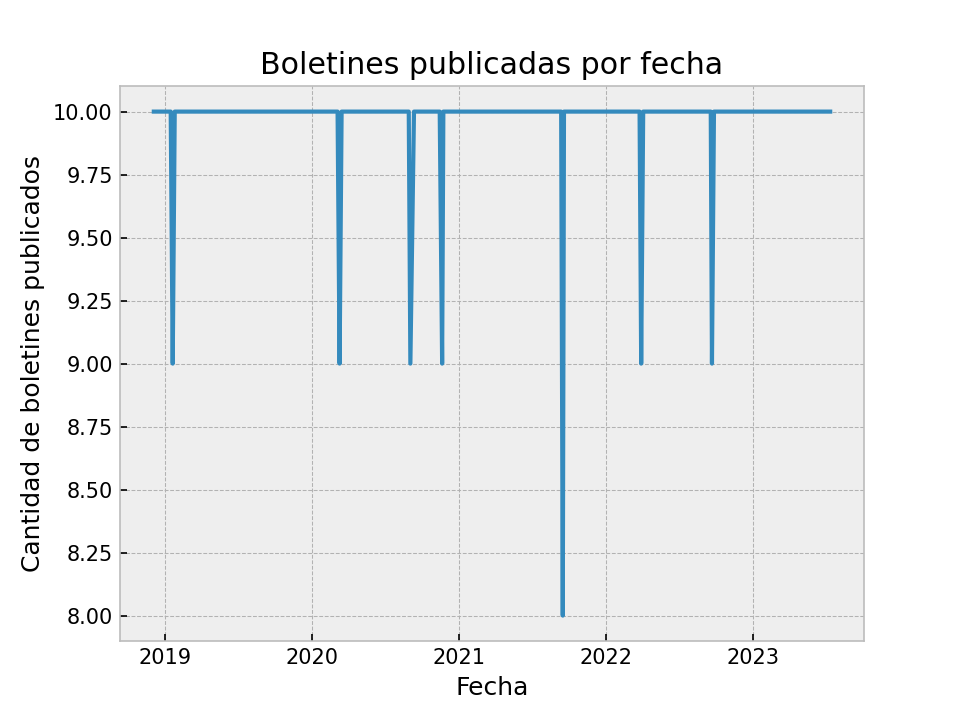

In [4]:
conteo = Counter(muestra.Fecha)
with plt.style.context('bmh'):
    fig, axs = plt.subplots()

    axs.plot(conteo.keys(),conteo.values())
    plt.title("Boletines publicadas por fecha")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad de boletines publicados")

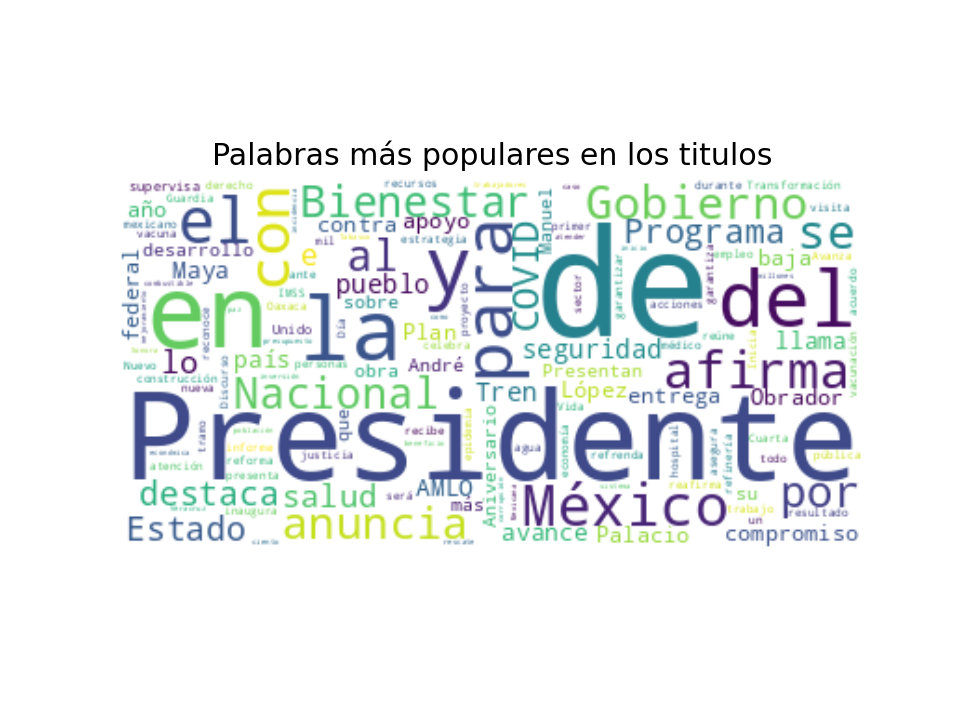

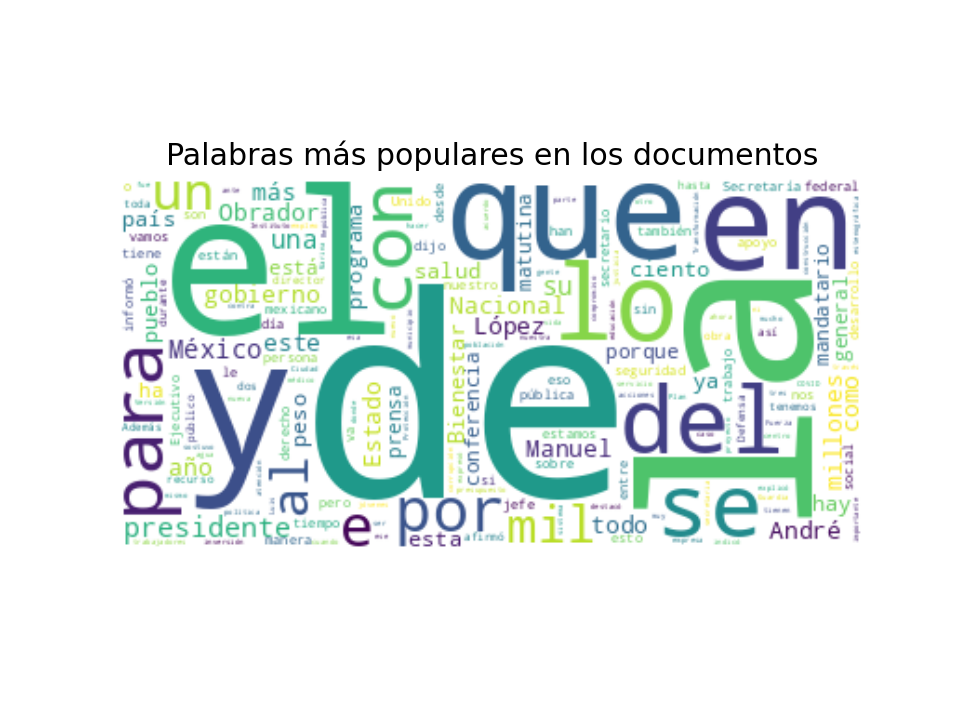

In [5]:
cloud_text = " ".join(titulo for titulo in muestra.Título)
cloud_contenido = " ".join(contenido for contenido in muestra.Contenido)


word_cloud_titulo = WordCloud(collocations = False, background_color = 'white').generate(cloud_text)
word_cloud_contenido = WordCloud(collocations = False, background_color = 'white').generate(cloud_contenido)

with plt.style.context('bmh'):
    plt.imshow(word_cloud_titulo, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras más populares en los titulos")
    plt.show()

    plt.imshow(word_cloud_contenido, interpolation='bilinear')
    plt.axis("off")
    plt.title("Palabras más populares en los documentos")
    plt.show()

Limpiado y otra graficacion

In [6]:
preprosesado = muestra.copy()

stopword_es = nltk.corpus.stopwords.words('spanish')
tiempos_unigram = {}
tiempos_bigram = {}

for max_df in tqdm(range(1,200)):
    
    print(max_df)
    frecuencias_del_corpus = TfidfVectorizer(
        ngram_range = (1,1),
        max_df=max_df,
        min_df=max_df,
        stop_words=stopword_es
    )
    corpus_vectorizado = frecuencias_del_corpus.fit_transform(preprosesado.Contenido) 
    tiempos_unigram[max_df] =len(frecuencias_del_corpus.vocabulary_)

    frecuencias_del_corpus = TfidfVectorizer(
        ngram_range = (2,2),
        max_df=max_df,
        min_df=max_df,
        stop_words=stopword_es,
        strip_accents='unicode'
        )
    corpus_vectorizado = frecuencias_del_corpus.fit_transform(preprosesado.Contenido) 
    tiempos_bigram[max_df] = len(frecuencias_del_corpus.vocabulary_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
---------------------------------------------------------
ValueError              Traceback (most recent call last)
Cell In[214], line 26
     17 tiempos_unigram[max_df] =len(frecuencias_del_corpus.vocabulary_)
     19 frecuencias_del_corpus = TfidfVectorizer(
     20     ngram_range = (2,2),
     21     max_df=max_df,
   (...)
     24     strip_accents='unicode'
     25     )
---> 26 corpus_vectorizado = frecuencias_del_corpus.fit_transform(preprosesado.Contenido) 
     27 tiempos_bigram[max_df] = len(frecuencias_del_corpus.vocabulary_)

File ~/miniconda3/envs/pln_noticias

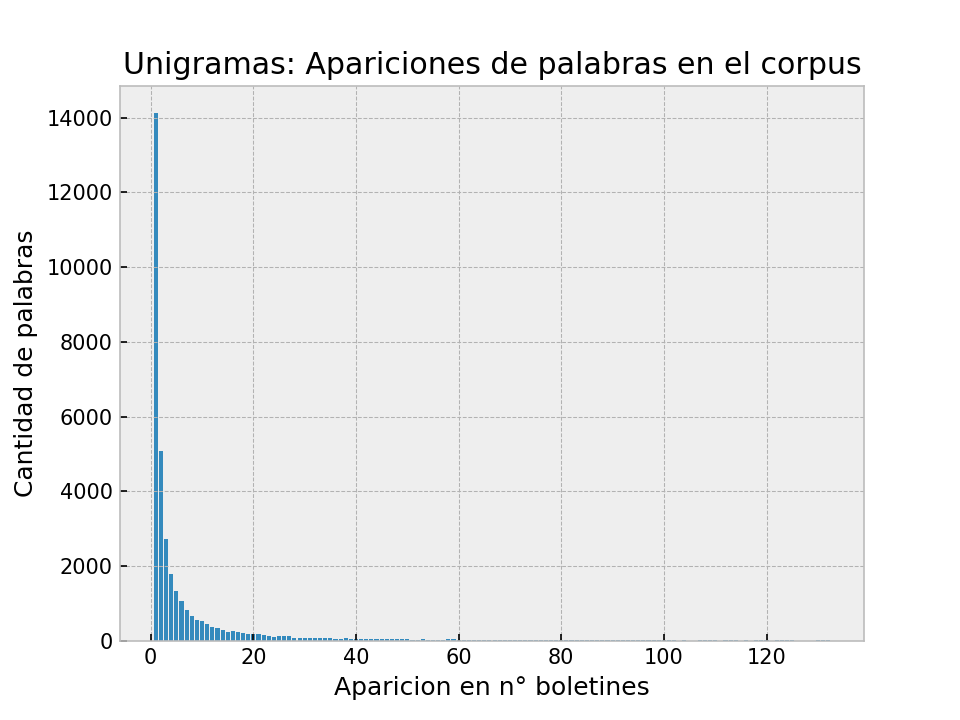

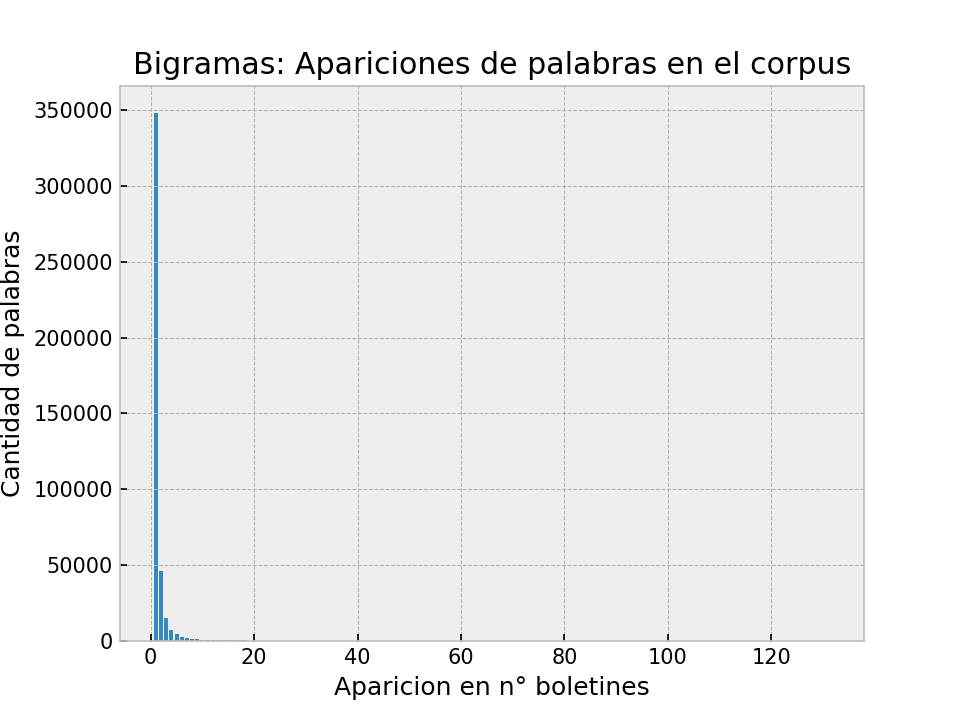

In [7]:
with plt.style.context('bmh'):
    plt.bar(tiempos_unigram.keys(),tiempos_unigram.values())
    plt.title("Unigramas: Apariciones de palabras en el corpus")
    plt.xlabel("Aparicion en n° boletines")
    plt.ylabel("Cantidad de palabras")
    plt.show()
    
    plt.bar(tiempos_bigram.keys(),tiempos_bigram.values())
    plt.title("Bigramas: Apariciones de palabras en el corpus")
    plt.xlabel("Aparicion en n° boletines")
    plt.ylabel("Cantidad de palabras")
    plt.show()

In [8]:
frecuencias_boletines = TfidfVectorizer(
    ngram_range = (1,1),
    max_df=160,
    min_df=8,
    stop_words=stopword_es
    )
boletines_vectorizados = frecuencias_boletines.fit_transform(preprosesado.Contenido)

n_topics_LDA = 16
lda = LatentDirichletAllocation(
    n_components=n_topics_LDA,
)
lda.fit(boletines_vectorizados)

LatentDirichletAllocation(n_components=16)

In [9]:
from random import randint
def Clasificar_noticia(indice):
    noticia_vectorizada = frecuencias_boletines.transform(
        preprosesado.Contenido[indice:indice+1])
    return lda.transform(noticia_vectorizada) 



topico_a_buscar = 13 
tamaño_muestra = 5
print (f"Topico:{topico_a_buscar}")
while tamaño_muestra != 0 :

    indice = randint(0, len(preprosesado))
    noticia = preprosesado.iloc[indice]      

    probabilidad_topicos= Clasificar_noticia(indice)
    topico_mas_probable = probabilidad_topicos.argmax()
    if  topico_a_buscar == -1 or topico_mas_probable == topico_a_buscar:
        print(f"indice:{indice} - {noticia.Título} \n")
        tamaño_muestra-=1

Topico:13
indice:141 - Presidente supervisa tramo 5 del Tren Maya y Aeropuerto Felipe Carrillo Puerto en Tulum 

indice:269 - Terminados, 600 kilómetros de terracerías del Tren Maya; presidente supervisa tramos 2 y 3 

indice:2046 - Tren Maya resaltará grandeza cultural y natural del sureste de México: presidente 

indice:170 - Presidente concluye gira de supervisión del Tren Maya con reunión y sobrevuelo 

indice:270 - Tren Maya es un sueño que pronto será realidad: presidente; constata avances en tramos 4 y 5 

